In [ ]:
!sudo apt update
!sudo apt install -y software-properties-common
!sudo add-apt-repository -y ppa:deadsnakes/ppa
!sudo apt install -y python3.13  # или python3.13, если доступно

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libpython3.13-stdlib
Suggested packages:
  python3.13-venv
The following NEW packages will be installed:
  libpython3.13-stdlib python3.13
0 upgraded, 2 newly installed, 0 to remove and 35 not upgraded.
Need to get 5,493 kB of archives.
After this operation, 21.5 MB of additional disk space will be used.
Get:1 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy/main amd64 libpython3.13-stdlib amd64 3.13.3-1+jammy1 [2,979 kB]
Get:2 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy/main amd64 python3.13 amd64 3.13.3-1+jammy1 [2,513 kB]
Fetched 5,493 kB in 2s (2,274 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 2.)
debconf: falling back to frontend: Rea

In [ ]:
!curl -sS https://bootstrap.pypa.io/get-pip.py | python3.13

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.7 MB/s eta 0:00:00


In [ ]:
!pip3 install /content/mlgrad-0.7.1-cp313-cp313-linux_x86_64.whl

Processing ./mlgrad-0.7.1-cp313-cp313-linux_x86_64.whl
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 77.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [mlgrad]


In [338]:
import matplotlib.pyplot as plt
import sklearn.datasets as datasets
import sklearn.preprocessing as preprocessing
import sklearn.decomposition as decomposition
import numpy as np

import mlgrad.loss as loss
import mlgrad.funcs as funcs
import mlgrad.funcs2 as funcs2
import mlgrad.models as models
from mlgrad.cls import classification_as_regr
import mlgrad.plots as plots

import pandas as pd

In [339]:
X, Y = datasets.load_wine(return_X_y=True)

In [340]:
import sklearn.decomposition as decomposition
import sklearn.preprocessing as preprocessing

In [341]:
pca = decomposition.PCA()
pca.fit(X)

PCA()

In [342]:
U = pca.transform(X)
U = U[:,:2]

In [343]:
U2 = U[Y != 0]
Y2 = Y[Y != 0]

In [344]:
np.putmask(Y2, Y2 == 1, -1)
np.putmask(Y2, Y2 == 2, +1)

In [345]:
Y2 = Y2.astype('d')

In [346]:
U2 = preprocessing.scale(U2)

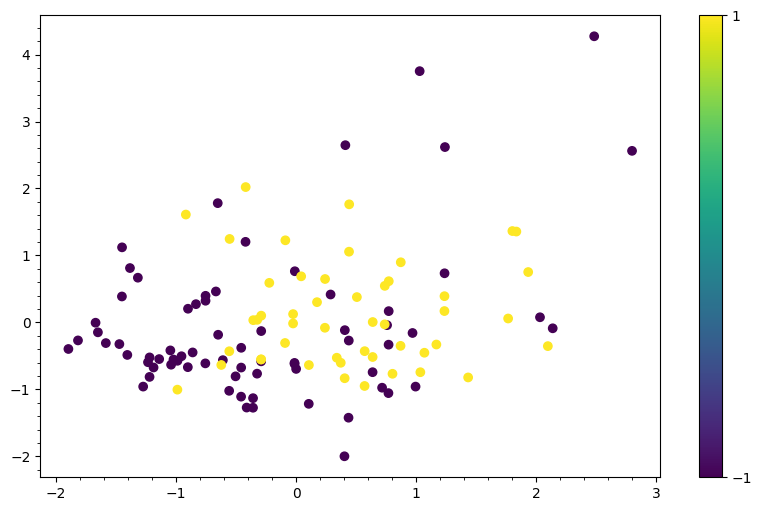

In [347]:
plt.figure(figsize=(10,6))
sc = plt.scatter(U2[:,0], U2[:,1], c=Y2)
plt.colorbar(sc,ticks=[-1,+1])
plt.minorticks_on()
plt.show()

In [375]:
n_hidden1 = 101
n_hidden2 = 101
n_hidden3 = 101
body = models.FFNetworkModel()
body.add(models.LinearLayer(2, n_hidden1))
body.add(models.ScaleLayer(funcs.Sigmoidal(5.0), n_hidden1))
body.add(models.LinearLayer(n_hidden1, n_hidden2))
body.add(models.ScaleLayer(funcs.Sigmoidal(4.0), n_hidden2))
body.add(models.LinearLayer(n_hidden2, n_hidden3))
body.add(models.ScaleLayer(funcs.Sigmoidal(4.0), n_hidden3))
head = models.LinearModel(body.n_output)
nnmod = models.FFNetworkFuncModel(head, body)

In [376]:
nnmod.allocate()
nnmod.init_param()

In [377]:
alg = classification_as_regr(U2, Y2, nnmod,
                             lossfunc=loss.MarginLoss(funcs.Hinge(1.0)),
                             regnorm=funcs2.SquareNorm(), tau=0.001,
                             h=0.001)

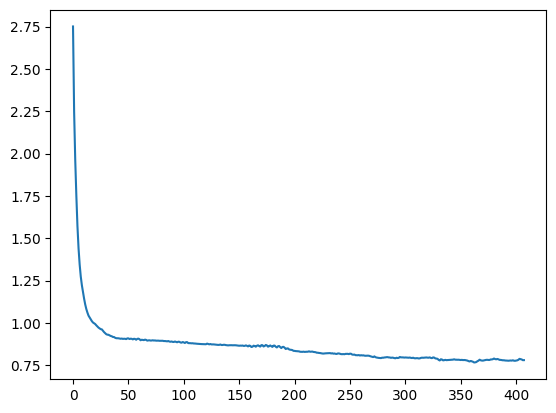

In [378]:
plt.plot(alg.lvals)
plt.show()

In [373]:
def calc_zz(mod, min_val, max_val):
    xrange = np.linspace(min_val, max_val, 201)
    yrange = np.linspace(min_val, max_val, 201)
    XX, YY = np.meshgrid(xrange, yrange)
    XY = np.c_[XX.ravel(), YY.ravel()]

    ZZ = []
    for xy in XY:
      ZZ.append(mod.evaluate(xy))

    ZZ = np.array(ZZ)

    ZZ = ZZ.reshape(XX.shape)
    return ZZ

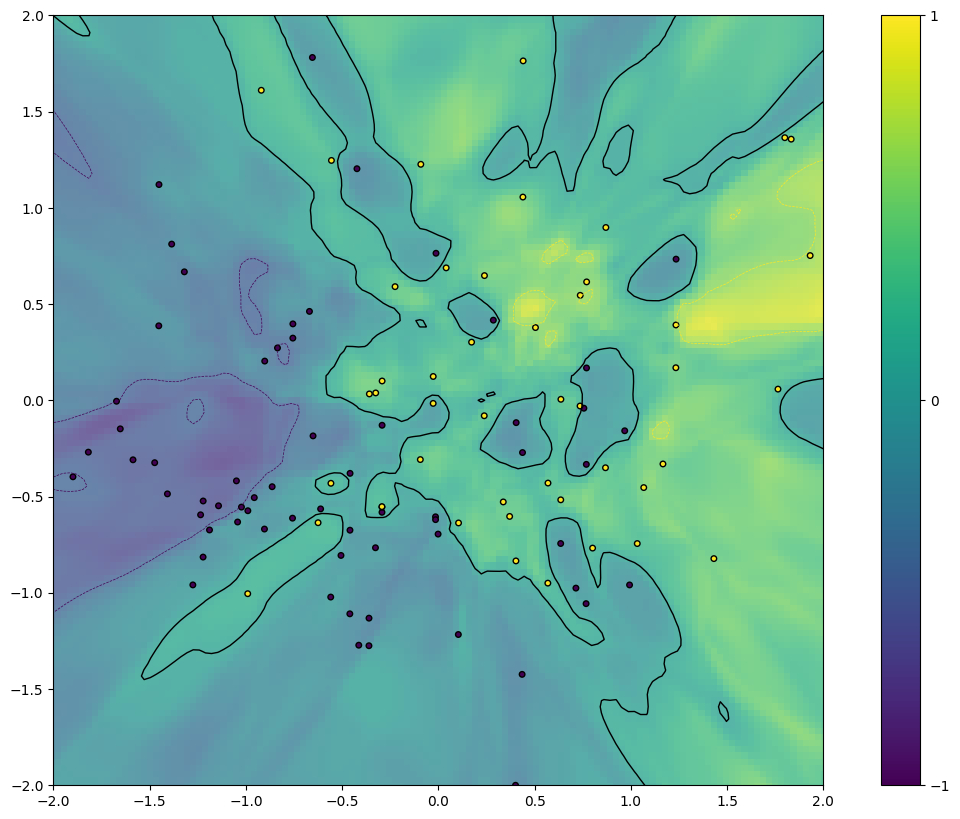

In [379]:
ZZ = calc_zz(nnmod, -3.2, 3.2)
plt.figure(figsize=(15,10))
cs = plt.scatter(U2[:,0], U2[:,1], c=Y2, edgecolors='k', s=16)
plt.imshow(ZZ, origin='lower', extent=(-3.2, 3.2,-3.2, 3.2), alpha=0.75)
plt.colorbar(cs, ticks=[-1,0,1])
plt.contour(ZZ, levels=[0], origin='lower', extent=(-3.2, 3.2,-3.2, 3.2), linewidths=1, colors='k')
plt.contour(ZZ, levels=[-5,5], origin='lower', extent=(-3.2, 3.2,-3.2, 3.2), linewidths=0.5, linestyles='--')
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.show()

In [380]:
from sklearn.metrics import accuracy_score

In [386]:
predict = []

for x in U2:
  predict.append(nnmod.evaluate(x))

accuracy_score(Y2, np.sign(predict))*100 # Доля правильных ответов

98.31932773109243

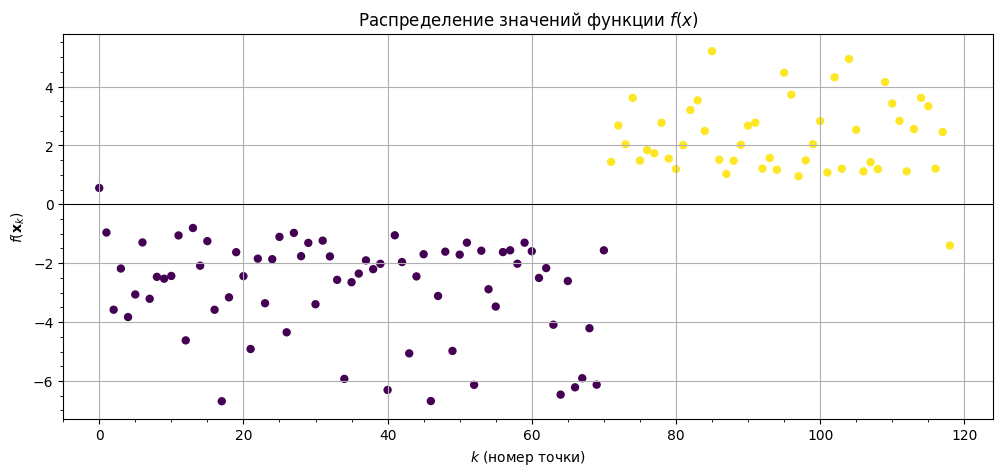

In [382]:
plt.figure(figsize=(12,5))
plots.plot_cls_function(nnmod, U2, Y2)
plt.show()